# Desafio #QuarentenaDados

Este Notebook foi elaborado por Bruno Fontana da Silva.

Em caso de dúvidas, em contato através de `fontanads@gmail.com`.

**Obs.:** para o treinamento da rede neural com PyTorch, é necessário habilitar o processamento com GPUs. 

Esse treinamento foi realizado utilizando o Google Colab. Mais instruções são detalhadas abaixo.

---

As instruções abaixo são do Notebook base da Alura.

> *Vamos trabalhar com uma amostra aleatória da base de dados MICRODADOS ENEM 2018, essa amostra é **diferente da apresentada em aula**.*
>
> *Seu objetivo é prever da melhor forma possível a nota das provas de **linguagens e códigos** (`NU_NOTA_LC`), dado todas as outras notas.*
>
> *O modelo que tiver o menor **erro quadrático médio (MSE)** vence o desafio.*

> *Para o desafio você tem três bases à disposição, duas para desenvolver seu modelo e uma para submissão da predição.*
>
> *As bases são as seguintes:*
>
> - **`dados_treino`**: *São $1500000$ linhas contendo a nota das $4$ provas + nota de > redação.*
>
> - **`dados_teste`**: *São $20000$ linhas contendo com notas das $4$ provas + nota de redação.*
>
> - **`dados_desafioqt`**: *São $10000$ linhas com nota de $3$ provas + nota de redação. A nota da prova de **Linguagem e Codigos** (`NU_NOTA_LC`) não está disponível nessa base.*
>
> *As base **dados_treino e dados_teste**, contém as seguintes colunas; **`NU_NOTA_CN`, `NU_NOTA_CH`, `NU_NOTA_MT`, `NU_NOTA_REDACAO`, `NU_NOTA_LC`**.* 
>
> *A coluna que você deve realizar a **previsão** é **NU_NOTA_LC**.*
>
> *Você pode manipular os dados da forma que quiser, o importante é que no final submeta o arquivo com as informações corretas (detalhes da submissão serão discutidos no final deste notebook).*
>
> *A base **`dados_desafioqt`**, contém as seguintes colunas; **`ID`, `NU_NOTA_CN`, `NU_NOTA_CH`, `NU_NOTA_MT`, `NU_NOTA_REDACAO`**.*
>
> *Repare que os dados **`NU_NOTA_LC`** não estão presentes, essa é justamente a informação que você precisa prever.*
>
> *Nós temos os valores reais das notas, no final do prazo de submissão um script irá avaliar sua previsão e dará uma nota para o seu modelo.* 
>
> *Nessa base também temos o **`ID`**, essa informação é importante para o envio da sua previsão, garanta que a nota prevista corresponda ao respectivo **`ID`**.*
>
> *Se você está habituado com o desenvolvimento de modelos de ML, repare que essa divisão de dados é exatamente a mesma que Treino, Teste e Validação.*
>
> *Abaixo preparamos um código exemplo para você seguir, sinta-se à vontade para experimentar diversos outros métodos, mas **GARANTA QUE O ARQUIVO DE SUBMISSÃO ESTEJA CONFIGURADO CORRETAMENTE**.*



# Carregando Bibliotecas

In [0]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
import time
from IPython.display import clear_output

In [0]:
SEED=42

# Helper Functions

Aqui vão algumas funções auxiliares para facilitar a legibilidade do código.

In [0]:
def get_clusters(dados):  # feature engineering: criando a feature categórica 'cluster'
  
  if isinstance(dados, pd.DataFrame):
    # os limiares para cada nota foram selecionados 
    # após analisar diversas vezes o padrão de erro absoluto 
    # nos testes do modelo treinado
    filtro = (dados['NU_NOTA_CN']           > 400)           # & (dados['NU_NOTA_CN']  < 600)) # é interessante liberar um limitante superior
    filtro = filtro & (dados['NU_NOTA_CH']  > 500)           # & (dados['NU_NOTA_CH']  < 750)) # para visualizar o efeito de seleção nas regiões
    filtro = filtro & (dados['NU_NOTA_MT']  > 350)           # & (dados['NU_NOTA_MT']  < 700)) # no gráfico de dispersão do sns.pairplot
    filtro = filtro & (dados['NU_NOTA_REDACAO']  > 500)
    filtro = filtro & (dados['nota_soma_sem_LC'] > media_feature)
    filtro = filtro.replace({ True: 1000, False: -1000 })
  else:
    filtro =          (dados[:,0] > 400)
    filtro = filtro & (dados[:,1] > 500)
    filtro = filtro & (dados[:,2] > 350)
    filtro = filtro & (dados[:,3] > 500)
    filtro = filtro & (dados[:,4] > media_feature)

    filtro_out = filtro.astype(np.float64)
    filtro_out[filtro]                = 1000
    filtro_out[np.logical_not(filtro)]=-1000
    
    filtro = filtro_out
  return filtro

In [0]:
def new_features(data_tuple): # recebe DataFrames em uma tupla para adicionar novas colunas (novas features)
  for dados in data_tuple:
    
    dados['nota_soma_sem_LC'] = dados.drop(ycol,axis=1).sum(axis=1)                                   # soma das notas, ignorando a variável dependente que será estimada
    dados['mediana_sem_LC']   = dados.drop(ycol,axis=1).median(axis=1)                                # mediana das notas, também ignorando a variável dependente
  
    clusters = get_clusters(dados) # nova feature: cluster binário,
    dados['cluster']   = clusters  # valor categórico (binário) classificando notas em dois grupos
  
  return data_tuple           # retorna tupla de DataFrames modificados

In [0]:
def transformar(notas): # transformar features numpy para espaço log
  if isinstance(notas, list): # expect use of list for single row only
    notas = np.array(notas).reshape(1,-1)
  Nrows = notas.shape[0]
  notas = notas.reshape(Nrows,-1)
  soma    = notas.sum(axis=1).reshape(Nrows,-1)         # feature 'nota_soma_sem_LC'
  mediana = np.median(notas,axis=1).reshape(Nrows,-1)   # feature 'mediana_sem_LC'
  notas = np.concatenate((notas,soma),axis=1)       
  cluster_val = get_clusters(notas).reshape(Nrows,-1)   # feature 'cluster'

  notas = np.concatenate((np.array(notas),mediana,cluster_val),axis=1) # monta o vetor de features
  notas_log = notas/1000                                               # scaling por 1000
  notas_log[:,:-1] = np.log(notas_log[:,:-1]+eps)                      # transforma para o domínio log as features quantitativas
  return notas_log

In [0]:
def plot_training_performance(losses): # plot dos valores da função custo (loss) ao longo do treinamento da rede neural
  xplot = np.linspace(0,max_epochs,len(losses))
  yplot = np.array(losses)**.5
  plt.plot(xplot, yplot)
  plt.xlabel('epochs')
  plt.ylabel('LOSS RMSE')
  #plt.yscale('log')
  #plt.ylim([0,1e6])
  plt.grid()

  mean_RMSE_loss = np.sqrt(np.mean(losses[-100:]))
  plt.plot([0,xplot.max()],[mean_RMSE_loss,mean_RMSE_loss],'-',color='r',linewidth=3)
  plt.show()
  print(f'Mean RMS Loss: {mean_RMSE_loss:10.6f}')

In [0]:
def plot_y_pred_hist(y_val_tensor):             # histogram simples para visualizar brevemente a distribuição dos valores estimados 
  y_test_pred = y_val.round().cpu().numpy()
  plt.hist(y_test_pred)                
  plt.ylabel('count')
  plt.xlabel('output')
  plt.xlim([0,1000])
  plt.grid()
  plt.show()

# Leitura dos Dados

In [0]:
URI_TREINO    = "https://github.com/tgcsantos/quaretenadados/blob/master/DADOS_TREINO.csv?raw=true"
URI_TESTE     = "https://github.com/tgcsantos/quaretenadados/raw/master/DADOS_TESTE.csv"
URI_DESAFIOQT = "https://github.com/tgcsantos/quaretenadados/raw/master/DESAFIOQT.csv"

In [0]:
dados_treino    = pd.read_csv(URI_TREINO)
dados_teste     = pd.read_csv(URI_TESTE)
dados_desafioqt = pd.read_csv(URI_DESAFIOQT)

In [0]:
erro_treino    = "Erro ao carregar dados de treino"
erro_teste     = "Erro ao carregar dados de teste"
erro_desafioqt = "Erro ao carregar dados de submissão"

assert dados_treino.shape    == (150000, 5), erro_treino
assert dados_teste.shape     ==  (20000, 5), erro_teste
assert dados_desafioqt.shape == ( 10000, 5), erro_desafioqt

# Data Exploration, Filtering, Feature Engineering

In [0]:
ycol = 'NU_NOTA_LC'

Aqui vou extrair um valor médio (escolhi a mediana) da soma das notas (excluindo a '`NU_NOTA_LC`')

In [17]:
dados = pd.concat([dados_treino,dados_teste],axis=0, ignore_index=True)
media_feature = dados.drop(ycol,axis=1).sum(axis=1).median()
low_score = 250
print(media_feature)  

2075.6000000000004


Então adiciono **novas colunas** (novas *features*) aos DataFrames de Treino e Teste:

In [18]:
dados_treino, dados_teste= new_features((dados_treino, dados_teste))
dados_treino.columns

Index(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'nota_soma_sem_LC', 'mediana_sem_LC', 'cluster'],
      dtype='object')

In [0]:
xcols = dados_treino.drop(ycol,axis=1).columns.tolist() # leitura dos nomes das colunas do DataFrame resultante

In [0]:
dados_treino = dados_treino[[ycol]+xcols]               # reorganizando as colunas do DataFrame de treino

### Exploração dos dados

In [21]:
dados_treino.describe()                                 # estatísticas descritivas do DataFrame de treino

,NU_NOTA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_MT,NU_NOTA_REDACAO,nota_soma_sem_LC,mediana_sem_LC,cluster
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,528.526903,493.890438,570.752255,535.615000,516.269867,2116.527560,556.422154,-168.666667
std,72.385368,74.154695,79.399706,103.033382,184.355231,358.059659,86.937278,985.676434
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1000.000000
25%,477.900000,435.800000,513.300000,455.500000,360.000000,1854.000000,488.200000,-1000.000000
50%,533.400000,483.600000,584.900000,516.700000,520.000000,2075.400000,550.200000,-1000.000000
75%,581.400000,542.500000,629.600000,600.900000,640.000000,2334.200000,617.400000,1000.000000
max,787.400000,869.600000,825.800000,996.100000,1000.000000,3486.000000,964.400000,1000.000000


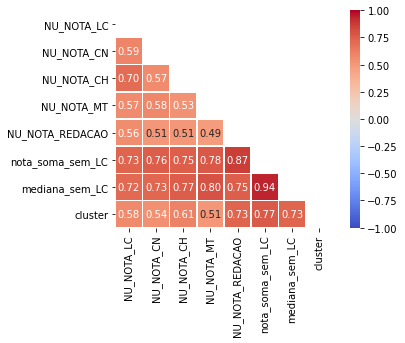

In [22]:
corr = dados_treino.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Matriz de Correlação com HeatMap
sns.heatmap(corr, vmin=-1,vmax=1, cmap='coolwarm', mask=mask, square=True, annot=True,fmt=".2f", linewidths=.5)

Abaixo, uso a *feature* categórica '`cluster`' para destacar as notas `LC` cujas combinações de notas `CN`, `CH`, `MT` e `REDACAO` está em um grupo ou em outro. 

Manipule os limiares dentro da *helper function* `get_clusters` e volte aqui para entender como os grupos se dividem.


<Figure size 1080x432 with 0 Axes>

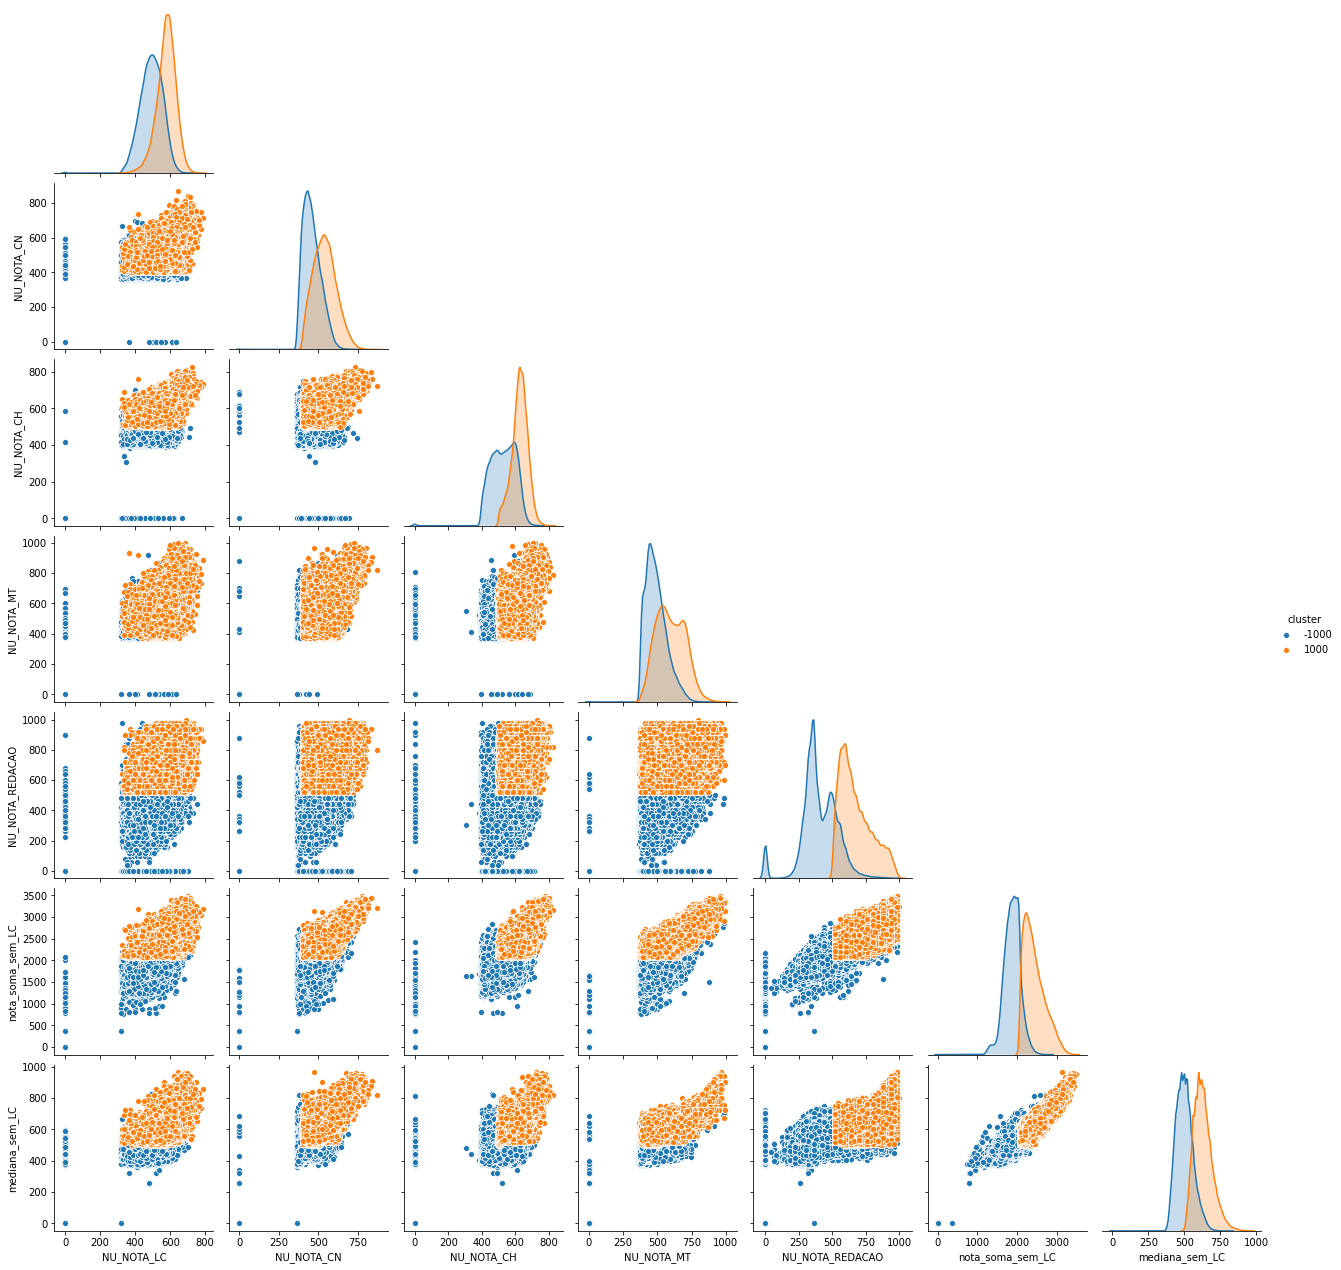

In [23]:
plt.figure(figsize=(15,6))
sns.pairplot(dados_treino,hue='cluster',diag_kind='kde',corner=True) # scatterplot dos pares de variáveis do DataFrame de Treino

In [0]:
#sns.pairplot(dados_teste,hue='cluster',diag_kind='kde',corner=True)  # scatterplot dos pares de variáveis do DataFrame de Teste

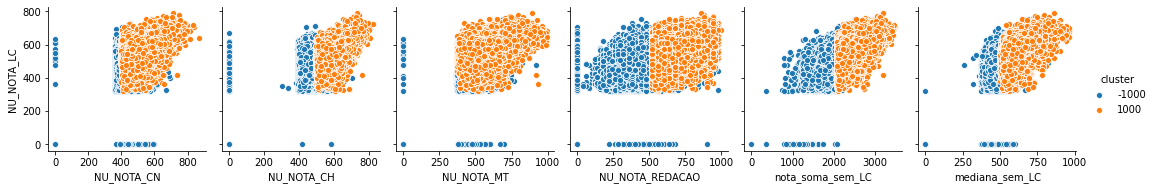

In [25]:
sns.pairplot(dados_treino,x_vars=xcols[:-1],y_vars=ycol,hue='cluster') # scatterplot da NOTA_LC vs. Features do DataFrame de treino
# sns.pairplot(dados_treino.query('NU_NOTA_MT==0'),x_vars=xcols,y_vars=ycol,hue='acima_da_media')

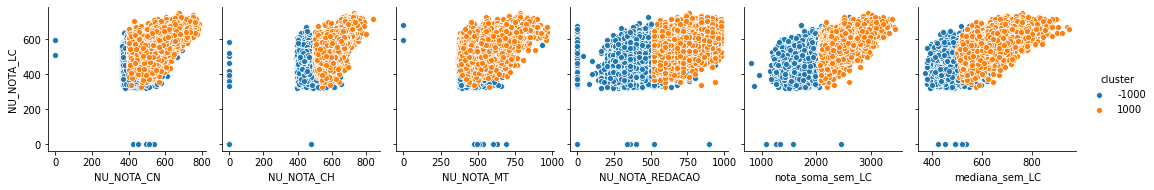

In [26]:
sns.pairplot(dados_teste,x_vars=xcols[:-1],y_vars=ycol,hue='cluster') # scatterplot da NOTA_LC vs. Features do DataFrame de treino3 33

In [27]:
# Esse trecho serve para remover do treino notas cuja soma de todas as features ou todas as notas (inclusive LC) sejam totalmente nulas.
# Entretanto, há apenas 1 ocorrência, portanto desisti de utilizar esses filtros. 
''' 
filtro_zerou_todas          = dados_treino.sum(axis=1)       ==0
filtro_zerou_todas_features = dados_treino[xcols].sum(axis=1)==0

idx = set()
for filtro in [filtro_zerou_todas, filtro_zerou_todas_features]:
    idx.update(i for i in dados_treino[filtro].index.tolist())
print(idx)

dados_treino = dados_treino.drop(index=idx).reset_index(drop=True)
print(len(dados_treino))
'''

' \nfiltro_zerou_todas          = dados_treino.sum(axis=1)       ==0\nfiltro_zerou_todas_features = dados_treino[xcols].sum(axis=1)==0\n\nidx = set()\nfor filtro in [filtro_zerou_todas, filtro_zerou_todas_features]:\n    idx.update(i for i in dados_treino[filtro].index.tolist())\nprint(idx)\n\ndados_treino = dados_treino.drop(index=idx).reset_index(drop=True)\nprint(len(dados_treino))\n'

### Separação Treino/Teste em Variáveis Numpy

Aqui seria um procedimento de "*re-shuffle*" entre dados e treino, estratificando pelos grupos acima e abaixo da média

Resolvi usar apenas $1\%$ para o testes, para tentar generalizar melhor durante o treinamento.

Para rodar na separação original, mudea `reshuffle_flag` para `False`.

In [28]:
reshuffle_flag = True

coluna_label    = ycol    # 'NU_NOTA_LC'
coluna_features = xcols   # ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_REDACAO'] + ['nota_soma_sem_LC', 'mediana_sem_LC', 'acima_da_media']

if reshuffle_flag:
  dados = pd.concat([dados_treino,dados_teste],axis=0, ignore_index=True)
  X = dados[coluna_features].to_numpy(dtype=np.float64)
  y = dados[coluna_label].to_numpy(dtype=np.float64)
  np.random.seed(SEED)
  X_treino, X_teste, Y_treino, Y_teste = train_test_split(X,y , shuffle=True, train_size=(168300)/170000) #, stratify=X[:,-1])
  print(X_treino.shape,Y_treino.shape, X_teste.shape, Y_teste.shape)
else:
  X_treino = dados_treino[coluna_features].to_numpy(dtype=np.float64)
  Y_treino = dados_treino[coluna_label].to_numpy(dtype=np.float64)
  X_teste  = dados_teste[coluna_features].to_numpy(dtype=np.float64)
  Y_teste  = dados_teste[coluna_label].to_numpy(dtype=np.float64)

(168300, 7) (168300,) (1700, 7) (1700,)


In [29]:
train_len = len(X_treino)
test_len  = len(X_teste)
val_len   = len(dados_desafioqt)

print(f' Train len: {train_len:5d}\n  Test len: {test_len:5d}')

 Train len: 168300
  Test len:  1700


Visualizando o histograma de `NOTA_LC` para o treino e para o teste.

Comparar com o resultado estimado pela rede neural.

Text(0.5, 0, 'Y Teste')

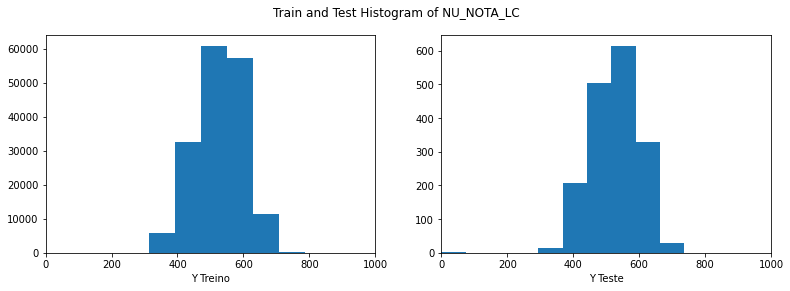

In [30]:
fig, axs =plt.subplots(1,2,gridspec_kw={'hspace': 2},figsize=(13,4))
fig.suptitle('Train and Test Histogram of NU_NOTA_LC')
axs[0].hist(Y_treino)
axs[0].set_xlim(0,1000)
axs[0].set_xlabel('Y Treino')

axs[1].hist(Y_teste)
axs[1].set_xlim(0,1000)
axs[1].set_xlabel('Y Teste')

## Dummy Baseline

## Model 0: DummyRegressor Baseline

>> *A seguir criamos um modelo **Dummy** como exemplo e realizamos a avaliação do modelo com o **mean_squared_error**.*
>>
>> *Você pode usar qualquer algoritmo ou biblioteca para criar seus modelos, mas garanta que fará a avaliação com o mean_squared_error, pois usaremos essa métrica para avaliar sua predição final.*

Modifiquei o código apenas para verificar se há alguma diferença entre a estratégia media e mediana.

In [31]:
for strategy in ['mean','median']:
    modelo_dummy = DummyRegressor(strategy=strategy)
    modelo_dummy.fit(X_treino, Y_treino)
    dummy_predicoes = modelo_dummy.predict(X_teste)
    avaliacao_dummy = mean_squared_error(Y_teste, dummy_predicoes)
    print(f"Test score: MSE {avaliacao_dummy:6.2f} RMSE {np.sqrt(avaliacao_dummy):6.2f} (dummy {strategy})")

Test score: MSE 5220.26 RMSE  72.25 (dummy mean)
Test score: MSE 5254.74 RMSE  72.49 (dummy median)


# Model 2: Rede Neural Artificial (ANN) com PyTorch

Nesta seção, fiz a implementação de um modelo de rede neural com PyTorch.

A rede será treinada com aprendizagem supervisionada para resolver o problema de regressão proposto.

## Classe do Modelo

Abaixo crio o modelo, que herda da classe `nn.Module` do PyTorch.

Modifico o construtor da classe para montar uma rede com várias camadas "_fully connected_" (FC) com função de ativação ReLU.

A ativação ReLU é interessante nesse problema porque opera como $\text{ReLU}(x) = \max(0,x)$.

Ou seja, impede saídas negativas ao mesmo tempo em que traz uma não-linearidade para a rede.

Implemento também o método `fit()` para treinar a rede com `batch-samples` do Dataset (em cada iteração, o *backpropagation* é aplicado várias vezes com pequenas batches em vez de propagar o conjunto inteiro de treino antes de atualizar os parâmetros da rede). 

As camadas `BatchNorm1d()` foram essenciais para melhorar o desempenho. Elas normalizam a variância e removem a média dos vetores gerados pelos nós de ativação. Durante o treinamento, essas camadas aprendem novos parâmetros de média $\beta$ e desvio padrão $\gamma$ ([*veja mais detalhes na doc. do PyTorch*](https://pytorch.org/docs/stable/nn.html#batchnorm1d)).

O método `predict()` faz uma estimativa das saída a partir dos dados de entrada, mas sem calcular os gradientes nem modificar o modelo. 

Note que ao fim do método `forward()` (propagação da entrada pela rede) eu acrescento a função `clamp()` na saída, para garantir que as notas estimadas serão limitadas entre $0$ e $1000$.

In [0]:
class MyModel(nn.Module):
    def __init__(self, n_features, layer_sizes, drop_probs):
        super().__init__()
        layers_list = []
        
        cnt = 0
        n_in = n_features
        for n_out,p in zip(layer_sizes, drop_probs):
            layers_list.append(nn.Linear(n_in, n_out))  # FC layer
            layers_list.append(nn.BatchNorm1d(n_out))   # Batch Normalization slows down and does not seem to work (maybe put it only once?)
            layers_list.append(nn.ReLU(inplace=True))   # activation function
            #layers_list.append(nn.Dropout(p=p))        # dropout layer, acabei não usando porque não parecia estar melhorando os resultados
            n_in = n_out 
            
        n_in, n_out = (n_out,1)
        layers_list.append(nn.Linear(n_in, n_out))  # final layer
        layers_list.append(nn.ReLU(inplace=True))   # final activation function
        self.layers = nn.Sequential(*layers_list)   # network object  
    
    def forward(self,x):
        x = self.layers(x)
        x = torch.clamp(x, 0, 1000)  # notas 0<=y<=1000
        return x

    def fit(self, X, Y, criterion, optimizer):
      losses=[]
      start_time = time.time()
      for i in range(max_epochs):
        data_samples = torch.utils.data.DataLoader(torch.cat([X,Y.view(train_len,-1)],dim=1), batch_size=batch_len, shuffle=True)
        batch_cnt = 0
        for sample in data_samples:
          X_batch = sample[:,:-1]
          Y_batch = sample[:,-1]
          batch_cnt+=1
          
          y_pred = self(X_batch).reshape(X_batch.shape[0]) # forward-prop in network
          loss = criterion(y_pred, Y_batch)                 # loss calculation
          RMSE_LOSS = torch.sqrt(F.mse_loss(y_pred,Y_batch))
          losses.append(loss.item())                       # save loss
          optimizer.zero_grad()                            # reset gradients
          loss.backward()                                  # backprop
          optimizer.step()                                 # params update
          
          # print status of current batch
          if batch_len<train_len:
            if batch_cnt%print_status_batch_iters==0:
              duration = time.time() - start_time 
              print(f'epoch {i} batch {batch_cnt} loss {loss:10.6f} RMSE Loss: {RMSE_LOSS:10.6f} (runtime: {duration:6.4f} sec)')
        
        # print status of current epoch
        if i%print_status_epoch_iters==0: 
          duration = time.time() - start_time 
          print(f'epoch {i} loss {loss:10.6f} RMSE Loss: {RMSE_LOSS:10.6f} Finished (runtime: {duration:6.4f} sec) ')
      
      # end of training, print duration         
      duration = time.time() - start_time 
      print(f' TRAINING FINISHED. Training took {duration/60:4.4f} min.')
      return losses, y_pred

    def predict(self,X,Y_True=None):
      with torch.no_grad():
        y_predicted = Model(X).reshape(X.shape[0])
        if Y_True is not None:
          loss  = criterion(y_predicted, Y_True)
          return y_predicted, loss
        return y_predicted

## Tensores e Transformação das Features Quantiativas

Para usar o PyTorch, é necessário converter os *datasets* em uma estrutura de dados chamada "**Tensores**".

Além disso, forçamos o método `cuda()` para utilizar processamento com GPU.

Para usar GPUs, ajuste a configuração:
> `Runtime > Change Runtime Type > Hardware Acceleartion > GPU`

no Google Colab.

Optei por fazer uma "escala" nos valores de entrada, dividindo todo dataset de entrada por $1000$.

Por fim, fiz uma transformação das *features* quantitativas para o domínio $\log$ (mapeando de $(0,1)$ até $(-\infty,0)$. O valor `eps` controla o limite do logaritmo quando a nota é de fato $0$. A feature `cluster` não é transformada.

In [0]:
eps = 1e-7

logX_treino = X_treino/1000
logX_treino[:,:-1] = np.log(logX_treino[:,:-1]+eps)

logX_teste = X_teste/1000
logX_teste[:,:-1] = np.log(logX_teste[:,:-1]+eps)

X_train = torch.FloatTensor(logX_treino).cuda()
X_test  = torch.FloatTensor(logX_teste).cuda()

Y_train = torch.FloatTensor(Y_treino).cuda()
Y_test  = torch.FloatTensor(Y_teste).cuda()

In [0]:
p = 0   # é utilizado como probabilidade de dropout dos ganhos da rede, mas está zerado porque os melhores resultados foram obtidos sem dropout
print_status_epoch_iters = 1    # print loss val. every 'print_status_epoch_iters' epoch-iterations during training
print_status_batch_iters = 1e9  # print loss val. every 'print_status_batch_iters' batch-iterations during training (valor está alto para ignorar o print)

Abaixo, a célula é utilizada para configura uma exploração de hiperparâmetros.

Para fazer varredura de hiperparâmetros, mude a *flag* `Ajustar_Hiperparametros` para `True`.

Cada variável do dicionário deve receber uma **lista** de valores para serem testados. Note que a busca pode ser muito demorada, pois o número de treinamentos será `Num_HyperParams_to_test`=$\prod\limits_{i=1}^{N_p} L_i$ onde $L_i$ é o número de valores possíveis do hiperparâmetro $p_i$. Além disso, cada busca pode ter maior ou menro complexidade dependendo das combinações de valores dos hiperparâmetros.

In [0]:
Ajustar_Hiperparametros = False     

param_dict = {}
param_dict['learning_rate'] = [2e-2] # exemplos de buscas: np.linspace(1e-2,5e-2,5) ou np.logspace(-3,-1,20)  
param_dict['L'] = [4,5]              # exemplos de buscas: np.arange(start=1,stop=4)
param_dict['Nu_exp'] = [5,6]         # exemplos de buscas: np.arange(10,15)

param_dict['max_epochs']= [10,30,50]     # maximum number of iterations running over the training set
param_dict['batch_len'] = [400,500,600]  # usar 'train_len' para evitar batch-training (mais lento, mas a função custo fica mais "suave")
param_dict['weight_decay'] = [1e-5]      # exemplos de buscas: np.logspace(-5,-3,10)  

Num_HyperParams_to_test = len(ParameterGrid(param_dict))

A seguir está o laço principal de treinamento.

Caso haja uma varredura de hiperparâmetros, uma lista de valores da função custo será salva para cada tupla de hiperparâmetros. Ao fim de todas as buscas, serão impressas as melhores $10$ combinações, associadas com a função custo em ordem crescente. 

**OBS:** após a varredura, mude a *flag* `Ajustar_Hiperparametros` para `False`, fixe os parâmetros desejados no fluxo do `else` e rode novamente o treinamento, para que o modelo seja fixado com os melhores parâmetros escolhidos por você.

Caso não haja uma varredura, será executada a condição do `else`, que **já está configurada com parâmetros encontrados durante exploração prévia**. Então a rede será treinada e estará pronta para uso após esse treino.

Model MyModel(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=32, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Linear(in_features=32, out_features=1, bias=True)
    (16): Re

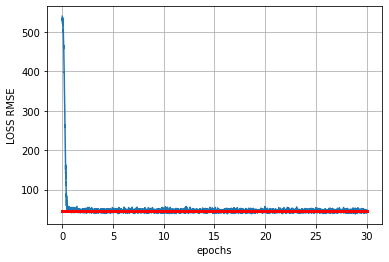

Mean RMS Loss:  45.362251
TEST SCORE: Torch loss 1967.979370 (ANN)
numpy double check  MSE 1967.979614 RMSE  44.361916


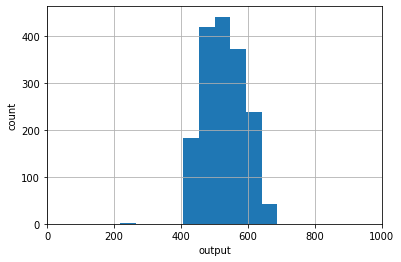

In [36]:
criterion = nn.MSELoss()
# provavelmente essa parte pode ser melhorada para diminuir a repetição de código 

if Ajustar_Hiperparametros:
  test_losses = []
  min_test_loss = np.inf
  best_params = None
  for idx, params in enumerate(ParameterGrid(param_dict)):
    learning_rate = params['learning_rate']      # learning rate for parameter updates
    weight_decay  = params['weight_decay']       # penalização da norma L2 dos parâmetros da rede
    L = params['L']                              # depth of ANN (number of hidden layers)
    Nu_exp = params['Nu_exp']                    # 2**Nu_exp = Number of units per HL
    max_epochs = params['max_epochs']            # num. of iterations over the full dataset
    batch_len =  params['batch_len']             # num. of samples to run backprop in batch-training 
      
    hidden_layer_sizes = (2**(Nu_exp*np.ones(L,dtype=np.int16))).tolist()  # this is a list of the number of units in each Fully-Connected hidden layer, e.g. [16, 4, 2]
    p_vec = p*np.ones(len(hidden_layer_sizes))

    print(f'Testing parameters {idx+1}/{Num_HyperParams_to_test}: {params}')

    torch.manual_seed(SEED)
    Model = MyModel(X_train.shape[1], layer_sizes=hidden_layer_sizes,drop_probs=p_vec).cuda() 
    optimizer = torch.optim.Adam(Model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)

    print(f'Model {Model}',f'Criterion: {criterion}',f'Optimizer: {optimizer}',sep=2*'\n')

    losses, y_pred = Model.fit(X=X_train, Y=Y_train,criterion=criterion, optimizer=optimizer)
    print(y_pred)

    y_val, test_loss = Model.predict(X=X_test,Y_True=Y_test)
    print(f'TEST SCORE: Torch loss {test_loss.item():10.6f}  (ANN)')
    print(f'numpy double check  MSE {mean_squared_error(y_val.cpu().numpy() ,Y_test.cpu().numpy()):10.6f} RMSE {mean_squared_error(y_val.cpu().numpy() ,Y_test.cpu().numpy())**0.5:10.6f}')

    if test_loss < min_test_loss:
      min_test_loss = test_loss
      best_params = params

    test_losses.append(test_loss)

    clear_output(wait=True)

else:
  
    learning_rate = 2e-2     # learning rate for parameter updates
    weight_decay  = 1e-5     # penalização da norma L2 dos parâmetros da rede
    L = 5                    # depth of ANN (number of hidden layers)
    Nu_exp = 5               # 2**Nu_exp = Number of units per HL
    max_epochs = 30          # num. of iterations over the full dataset
    batch_len =  400         # num. of samples to run backprop in batch-training  

    hidden_layer_sizes = (2**(Nu_exp*np.ones(L,dtype=np.int16))).tolist()  # this is a list of the number of units in each Fully-Connected hidden layer, e.g. [16, 4, 2]
    p_vec = p*np.ones(len(hidden_layer_sizes))

    torch.manual_seed(SEED)
    Model = MyModel(X_train.shape[1], layer_sizes=hidden_layer_sizes,drop_probs=p_vec).cuda()
    optimizer = torch.optim.Adam(Model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
    print(f'Model {Model}',f'Criterion: {criterion}',f'Optimizer: {optimizer}',sep=2*'\n')
    
    losses, y_pred = Model.fit(X=X_train, Y=Y_train,criterion=criterion, optimizer=optimizer)
    print(y_pred)

    plot_training_performance(losses)

    y_val, test_loss = Model.predict(X=X_test,Y_True=Y_test)
    print(f'TEST SCORE: Torch loss {test_loss.item():10.6f} (ANN)')
    print(f'numpy double check  MSE {mean_squared_error(y_val.cpu().numpy() ,Y_test.cpu().numpy()):10.6f} RMSE {mean_squared_error(y_val.cpu().numpy() ,Y_test.cpu().numpy())**0.5:10.6f}')
    
    plot_y_pred_hist(y_val)

A célula abaixo é para impressão dos melhores hiperparâmetros encontrados durante o caso de varredura.

In [0]:
if Ajustar_Hiperparametros:
  print(f'Got min RMSE loss {np.sqrt(min_test_loss.cpu().numpy()):.4f} with params {best_params}')
  test_losses_list = [np.sqrt(test_loss.item()) for test_loss in test_losses]
  ordered_losses = np.argsort(np.array(test_losses_list))
  top_10 = ordered_losses[:10]

  enumerated_params = [item for item in enumerate(zip(test_losses_list,ParameterGrid(param_dict)))]
  best_params_list = [enumerated_params[i] for i in top_10]
  for param in best_params_list:
    print(param)

In [0]:
''' 
# Exemplos das saídas quando está usando a varredura por hiperparâmetros:

Got min RMSE loss 44.2165 with params {'L': 5, 'Nu_exp': 5, 'batch_len': 400, 'learning_rate': 0.02, 'max_epochs': 30, 'weight_decay': 1e-05}
(19, (44.21649039058774, {'L': 5, 'Nu_exp': 5, 'batch_len': 400, 'learning_rate': 0.02, 'max_epochs': 30, 'weight_decay': 1e-05}))
(26, (44.256960908620776, {'L': 5, 'Nu_exp': 5, 'batch_len': 600, 'learning_rate': 0.02, 'max_epochs': 50, 'weight_decay': 1e-05}))
(20, (44.25791248333808, {'L': 5, 'Nu_exp': 5, 'batch_len': 400, 'learning_rate': 0.02, 'max_epochs': 50, 'weight_decay': 1e-05}))
(2, (44.27276956550155, {'L': 4, 'Nu_exp': 5, 'batch_len': 400, 'learning_rate': 0.02, 'max_epochs': 50, 'weight_decay': 1e-05}))
(8, (44.285307682825234, {'L': 4, 'Nu_exp': 5, 'batch_len': 600, 'learning_rate': 0.02, 'max_epochs': 50, 'weight_decay': 1e-05}))
(5, (44.37354751143974, {'L': 4, 'Nu_exp': 5, 'batch_len': 500, 'learning_rate': 0.02, 'max_epochs': 50, 'weight_decay': 1e-05}))
(4, (44.429026035826936, {'L': 4, 'Nu_exp': 5, 'batch_len': 500, 'learning_rate': 0.02, 'max_epochs': 30, 'weight_decay': 1e-05}))
(13, (44.43532156668133, {'L': 4, 'Nu_exp': 6, 'batch_len': 500, 'learning_rate': 0.02, 'max_epochs': 30, 'weight_decay': 1e-05}))
(7, (44.453380381515984, {'L': 4, 'Nu_exp': 5, 'batch_len': 600, 'learning_rate': 0.02, 'max_epochs': 30, 'weight_decay': 1e-05}))
(10, (44.46491221141396, {'L': 4, 'Nu_exp': 6, 'batch_len': 400, 'learning_rate': 0.02, 'max_epochs': 30, 'weight_decay': 1e-05}))

Got min RMSE loss 45.5218 with params {'L': 5, 'Nu_exp': 6, 'batch_len': 500, 'learning_rate': 0.02, 'max_epochs': 10, 'weight_decay': 1e-05}
(293, (45.52180109573873, {'L': 5, 'Nu_exp': 6, 'batch_len': 500, 'learning_rate': 0.02, 'max_epochs': 10, 'weight_decay': 1e-05}))
(160, (45.628301464455696, {'L': 4, 'Nu_exp': 6, 'batch_len': 100, 'learning_rate': 0.01, 'max_epochs': 5, 'weight_decay': 1e-05}))
(45, (45.64902246437622, {'L': 3, 'Nu_exp': 6, 'batch_len': 100, 'learning_rate': 0.03, 'max_epochs': 10, 'weight_decay': 1e-05}))
(241, (45.686134662396476, {'L': 5, 'Nu_exp': 5, 'batch_len': 100, 'learning_rate': 0.01, 'max_epochs': 10, 'weight_decay': 1e-05}))
(320, (45.692675087377246, {'L': 5, 'Nu_exp': 7, 'batch_len': 100, 'learning_rate': 0.01, 'max_epochs': 5, 'weight_decay': 1e-05}))
(81, (45.752059806772635, {'L': 3, 'Nu_exp': 7, 'batch_len': 100, 'learning_rate': 0.01, 'max_epochs': 10, 'weight_decay': 1e-05}))
(51, (45.75273482689997, {'L': 3, 'Nu_exp': 6, 'batch_len': 500, 'learning_rate': 0.01, 'max_epochs': 10, 'weight_decay': 1e-05}))
(295, (45.76579037184188, {'L': 5, 'Nu_exp': 6, 'batch_len': 500, 'learning_rate': 0.03, 'max_epochs': 10, 'weight_decay': 1e-05}))
(330, (45.76629448554362, {'L': 5, 'Nu_exp': 7, 'batch_len': 500, 'learning_rate': 0.01, 'max_epochs': 5, 'weight_decay': 1e-05}))
(201, (45.79040544119204, {'L': 4, 'Nu_exp': 7, 'batch_len': 100, 'learning_rate': 0.01, 'max_epochs': 10, 'weight_decay': 1e-05}))

Got min RMSE loss 45.5909 with params {'L': 3, 'Nu_exp': 7, 'batch_len': 3000, 'learning_rate': 0.01, 'max_epochs': 50, 'weight_decay': 1e-05}
(54, (45.59085837300609, {'L': 3, 'Nu_exp': 7, 'batch_len': 3000, 'learning_rate': 0.01, 'max_epochs': 50, 'weight_decay': 1e-05}))
(64, (45.692381215820596, {'L': 3, 'Nu_exp': 8, 'batch_len': 3000, 'learning_rate': 0.01, 'max_epochs': 50, 'weight_decay': 0.0001}))
(65, (45.72410309142898, {'L': 3, 'Nu_exp': 8, 'batch_len': 3000, 'learning_rate': 0.01, 'max_epochs': 50, 'weight_decay': 0.001}))
(46, (45.74201336965148, {'L': 2, 'Nu_exp': 9, 'batch_len': 3000, 'learning_rate': 0.01, 'max_epochs': 50, 'weight_decay': 0.0001}))
(20, (45.747833367412056, {'L': 1, 'Nu_exp': 9, 'batch_len': 3000, 'learning_rate': 0.01, 'max_epochs': 50, 'weight_decay': 0.001}))
(55, (45.87787105712704, {'L': 3, 'Nu_exp': 7, 'batch_len': 3000, 'learning_rate': 0.01, 'max_epochs': 50, 'weight_decay': 0.0001}))
(37, (45.93124691709746, {'L': 2, 'Nu_exp': 8, 'batch_len': 3000, 'learning_rate': 0.01, 'max_epochs': 50, 'weight_decay': 0.0001}))
(11, (45.96365645641946, {'L': 1, 'Nu_exp': 8, 'batch_len': 3000, 'learning_rate': 0.01, 'max_epochs': 50, 'weight_decay': 0.001}))
(18, (46.04000839538232, {'L': 1, 'Nu_exp': 9, 'batch_len': 3000, 'learning_rate': 0.01, 'max_epochs': 50, 'weight_decay': 1e-05}))
(29, (46.0705635538776, {'L': 2, 'Nu_exp': 7, 'batch_len': 3000, 'learning_rate': 0.01, 'max_epochs': 50, 'weight_decay': 0.001}))
''';

## Checking some predictions

Visualizando algumas previsões da rede treinada para exemplos aleatórios.

In [39]:
for i in np.random.randint(low=0, high=test_len, size=10):
    pred_val  = y_val[i].item()
    true_val  = Y_test[i].item()
    diff = np.abs(true_val-pred_val)
    print(f'PREDICTED : {pred_val:5.2f} TRUE: {true_val:5.2f} |diff|: {diff:5.2f} | Input ID: {i}) ')

PREDICTED : 460.12 TRUE: 484.20 |diff|: 24.08 | Input ID: 313) 
PREDICTED : 593.50 TRUE: 624.60 |diff|: 31.10 | Input ID: 1595) 
PREDICTED : 577.61 TRUE: 542.40 |diff|: 35.21 | Input ID: 1053) 
PREDICTED : 551.82 TRUE: 496.30 |diff|: 55.52 | Input ID: 996) 
PREDICTED : 523.92 TRUE: 546.00 |diff|: 22.08 | Input ID: 51) 
PREDICTED : 558.94 TRUE: 615.80 |diff|: 56.86 | Input ID: 807) 
PREDICTED : 488.68 TRUE: 475.30 |diff|: 13.38 | Input ID: 727) 
PREDICTED : 607.16 TRUE: 600.20 |diff|:  6.96 | Input ID: 414) 
PREDICTED : 508.56 TRUE: 468.70 |diff|: 39.86 | Input ID: 1087) 
PREDICTED : 615.78 TRUE: 491.30 |diff|: 124.48 | Input ID: 1640) 


### Visualizando os casos que causaram os maiores erros

Essa seção é extremamente importante.

Através dessa análise, fui buscando insights sobre os padrões de erro e fui refinando o cluster da feature categórica adicionada em busca de redução do MSE.

Primerio, analisamos o **erro absoluto** vs. `NOTA_LC` *verdadeira* do teste.

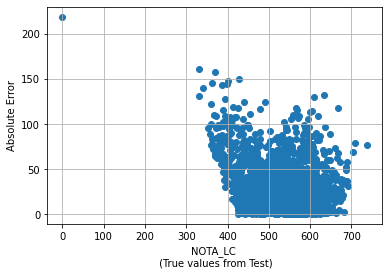

In [40]:
diff = torch.abs(y_val-Y_test)
largest_errors_idx = np.argsort(-diff.cpu().numpy())
plt.scatter(Y_test[largest_errors_idx].cpu().numpy(), diff[largest_errors_idx].cpu().numpy())
plt.xlabel('NOTA_LC \n (True values from Test)')
plt.ylabel('Absolute Error')
plt.grid()

Após, ordeno os erros absolutos do maior para o menor.

Assim posso saber exatamente os índices dos exemplos de teste que causaram os piores erros.

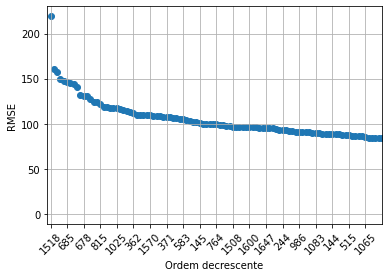

In [41]:
diff = torch.abs(y_val-Y_test)
largest_errors_idx = np.argsort(-diff.cpu().numpy())
plt.scatter(range(test_len),diff[largest_errors_idx].cpu().numpy())
plt.ylabel('RMSE')

max_pts = 100              # zoom nos 'max_pts' piores erros
step_tick = 5              # mostar tick a cada 'step_tick' valores (lembre também que os ticks não estão ordenados sequencialmente)

plt.xticks(ticks=range(0,max_pts,step_tick),labels=largest_errors_idx[:max_pts:step_tick],rotation=45)
plt.xlim([-1,max_pts])

plt.xlabel('Ordem decrescente')
plt.grid()

Por fim, tento visualizar como está a dispersão entre `NOTA_LC` e as features para os pontos com maiores erros absolutos (são as maiores contribuições para o MSE). A ideia aqui é observar algum padrão ou agrupamento para refinar a feature categórica `cluster`.

In [0]:
N = 30   # top N pontos com maior erro absoluto para visualizar na dispersão
top_N_inputs_with_largest_error = (X_teste[largest_errors_idx[:N]]) #ou 1000*X_test[...].cpu().numpy() para usar features transformadas em log

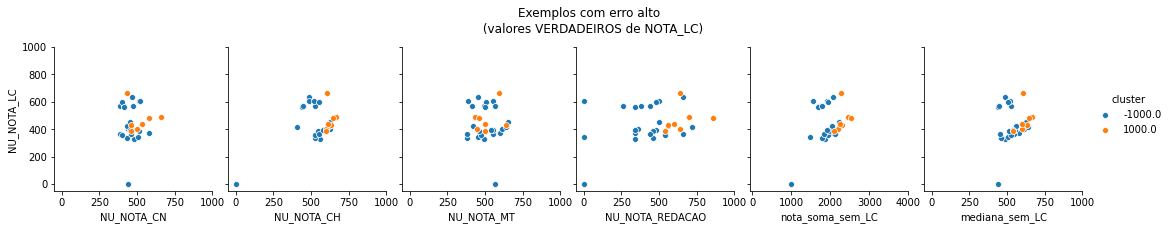

In [43]:
dados_top_N_largest_error = pd.DataFrame(top_N_inputs_with_largest_error,columns=coluna_features)
dados_top_N_largest_error[coluna_label] = Y_test[largest_errors_idx[:N]].cpu().numpy() 

fig = sns.pairplot(dados_top_N_largest_error,x_vars=coluna_features[:-1],y_vars=coluna_label,hue='cluster') # scatterplot da NOTA_LC vs. Features do DataFrame de treino
fig.fig.suptitle('Exemplos com erro alto \n (valores VERDADEIROS de NOTA_LC)',y=1.2)
ax = fig.axes

for n in range(6):
  ax[0,n].set_ylim(-50,1000)
  ax[0,n].set_xlim(-50,1000) if n != 4 else ax[0,n].set_xlim(-50,4000)

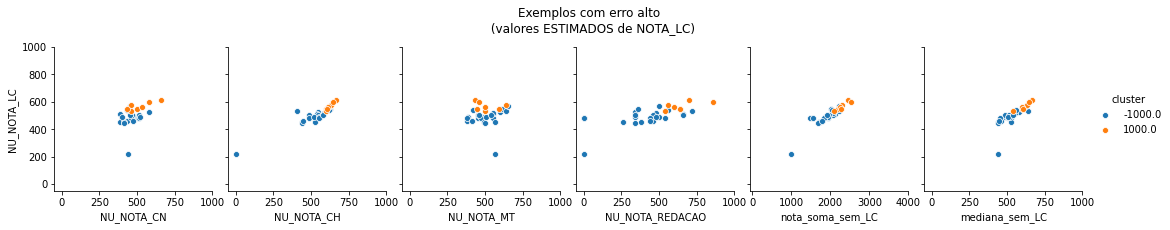

In [44]:
dados_top_N_largest_error = pd.DataFrame(top_N_inputs_with_largest_error,columns=coluna_features)
dados_top_N_largest_error[coluna_label] = y_val[largest_errors_idx[:N]].cpu().numpy() 
fig = sns.pairplot(dados_top_N_largest_error,x_vars=coluna_features[:-1],y_vars=coluna_label,hue='cluster') # scatterplot da NOTA_LC vs. Features do DataFrame de treino
fig.fig.suptitle('Exemplos com erro alto \n (valores ESTIMADOS de NOTA_LC)',y=1.2)
ax = fig.axes

for n in range(6):
  ax[0,n].set_ylim(-50,1000)
  ax[0,n].set_xlim(-50,1000) if n != 4 else ax[0,n].set_xlim(-50,4000)

# Submissão dos dados da previsão

> Depois que você criou testou e validou seu modelo, chegou a hora de preparar seu arquivo para a submissão do resultado.
> 
> No código abaixo, estamos realizando a predição das notas de **linguagem e códigos** do dataset **dados_desafioqt**. Feita a previsão, criamos um dataframe novo para a submissão, primeiro crimos a coluna **ID** e adicionamos a coluna **NU_NOTA_LC** com suas respectivas previsões (repare que nosso modelo não alterou as ordens dos ID's, mas se você utilizar algum modelo que embaralhe essa ordem certifique de colocar a previsão correta para o ID correto).
> 
> Após isso, salvamos o dataframe com ´.to_csv()´ (**importante, passe o parâmetro index=False para `.to_csv()`, caso contrário nosso script não computará sua nota**) no arquivo **PREDICAO_DESAFIOQT.csv (você precisa submeter o arquivo com esse nome, caso contrário nosso script de avaliação não computará sua nota**)  e utilizamos o `files.download` para baixar o arquivo em sua máquina local.
> 
> Feito tudo isso você está quase pronto para finalizar e submeter seu resultado. Você já baixou os dados, treinou e validou seu modelo, salvou sua previsão **no padrão ideal para submissão** e já está com o modelo baixado em sua máquina. Entretanto, ainda falta um detalhe: no momento de preencher o **forms** você precisa enviar seu código. Caso esteja usando os notebooks do colab siga as seguintes instruções para o download:
> 
> - Clique em **File** na parte superior esquerda.
> - Depois selecione a opção **Download .ipynb** (também aceitaremos o .py caso você prefira desenvolver seu projeto em um arquivo python).
>
>
> Pronto agora é só submeter seu resultado e torcer para levar um **Nintendo Switch** para casa.
> 
> Boa sorte!

In [0]:
#atribuir ao MODELO o nome do seu melhor modelo
from google.colab import files

MODELO = Model

# MODIFICAÇÃO PARA CRIAR AS FEATURES EXTRAS, as quais dependem apenas das features originais e de uma constante já fixada no pré-processamento
dados_desafio = dados_desafioqt.copy()   # faço uma cópia do dataset fornecido para não modificá-lo
X_desafioqt   = dados_desafio.drop(['ID'],axis=1).to_numpy(dtype=np.float64)   # pandas para numpy
dados_desafio['nota_soma_sem_LC'] = dados_desafio.sum(axis=1)
dados_desafio['mediana_sem_LC'] = dados_desafio.median(axis=1)
dados_desafio['cluster'] = get_clusters(dados_desafio)

soma_desafio = X_desafioqt.sum(axis=1).reshape(-1,1)
get_clusters(np.concatenate((X_desafioqt,soma_desafio),axis=1))


# MODIFICAÇÃO para converter de tipos do numpy() para Tensores
T = torch.FloatTensor(transformar(X_desafioqt)).cuda()   # converte para tensor, considerando o uso de GPU para previsão 
predicao_desafioqt = MODELO.predict(T).cpu().numpy()     # faz previsão (note o scaling /1000) e converte de volta para numpy
    
dados_desafio[coluna_label] = predicao_desafioqt         # salva coluna de previsão no dataset original de validação

# AQUI ESTÁ A SEQUÊNCIA PARA GERAR OS DADOS DE SUBMISSÃO
desafio_df = pd.DataFrame(dados_desafio.ID)              # cria um novo DataFrame apenas com a coluna de IDs
desafio_df[coluna_label] = predicao_desafioqt            # acrescenta as previsões associadas a cada ID

#NÃO TROCAR O NOME DO ARQUIVO DE SAÍDA (PREDICAO_DESAFIO)
desafio_df.to_csv('PREDICAO_DESAFIOQT.csv', index=False) 
files.download('PREDICAO_DESAFIOQT.csv')

## Pós-Verificação

Após fazer a validação, podemos "espiar" algumas estatísticas dos resultados de previsão.

In [47]:
dados_desafio

,ID,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_MT,NU_NOTA_REDACAO,nota_soma_sem_LC,mediana_sem_LC,cluster,NU_NOTA_LC
0,0,496.1,585.3,495.8,320.0,1897.2,495.95,-1000,505.263885
1,1,558.5,641.9,515.9,600.0,2317.3,579.25,1000,589.452454
2,2,493.1,566.6,512.0,520.0,2093.7,516.00,1000,518.027771
3,3,410.9,534.4,437.6,340.0,1725.9,424.25,-1000,458.938843
4,4,453.5,577.9,545.8,580.0,2161.2,561.85,1000,525.327271
...,...,...,...,...,...,...,...,...,...
9995,9995,433.5,606.6,451.5,480.0,11966.6,543.30,-1000,521.933777
9996,9996,399.5,441.9,548.4,360.0,11745.8,495.15,-1000,455.740723
9997,9997,508.5,598.0,511.7,440.0,12055.2,554.85,-1000,532.591187
9998,9998,530.9,637.4,630.9,520.0,12317.2,634.15,1000,582.406555


In [48]:
dados_desafio.describe()

,ID,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_MT,NU_NOTA_REDACAO,nota_soma_sem_LC,mediana_sem_LC,cluster,NU_NOTA_LC
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,493.699120,571.692870,535.307860,515.546000,7115.745850,586.766450,-65.400000,529.694580
std,2886.89568,73.512058,78.388181,103.141515,183.814419,2904.706383,91.630117,997.909025,59.248764
min,0.00000,0.000000,0.000000,0.000000,0.000000,1393.000000,160.000000,-1000.000000,46.897358
25%,2499.75000,436.100000,515.400000,455.100000,360.000000,4601.475000,520.287500,-1000.000000,480.807571
50%,4999.50000,483.650000,586.300000,517.550000,520.000000,7123.850000,576.850000,-1000.000000,526.532257
75%,7499.25000,542.700000,630.400000,601.000000,620.000000,9639.350000,640.200000,1000.000000,575.778763
max,9999.00000,771.100000,776.700000,946.500000,980.000000,13117.300000,918.700000,1000.000000,692.794800


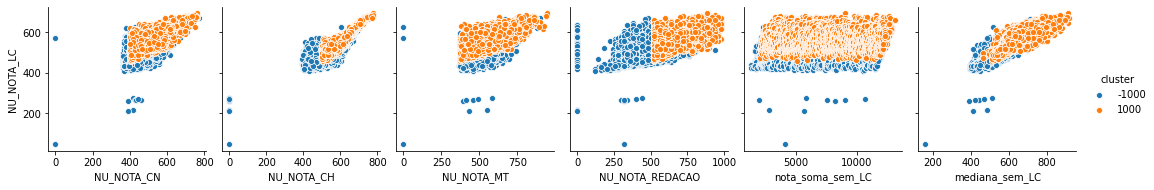

In [49]:
sns.pairplot(dados_desafio,x_vars=xcols[:-1],y_vars=ycol,hue='cluster') 
# NU_NOTA_LC são os valores estimados, não são os "verdadeiros" porque não temos acesso a eles antes do fim da competição
# de qualquer maneira, o comportamento parece semelhante com os dados de treino/teste, embora mais "ajustados" em termos de regressão linear

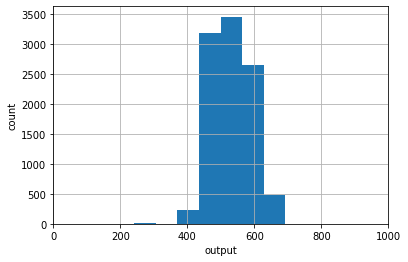

In [50]:
plt.hist(predicao_desafioqt) # just a histogram to quick view the distribution of soft prediction-values
plt.ylabel('count')
plt.xlabel('output')
plt.xlim([0,1000])
plt.grid()
plt.show()

Por fim, é interessante **verificar se o modelo generalizou bem** para outras entradas possíveis.

Abaixo analisamos alguns casos particulares.

In [51]:
notas_nulas     = transformar([0,0,0,0])                # Aluno com notas nulas
nota_gabarito   = transformar([1000,1000,1000,1000])    # Aluno que Gabaritou o ENEM
notas_identicas = transformar([10]*4)                   # Aluno com notas idênticas em todas as provas
T = torch.FloatTensor(np.array([notas_nulas,nota_gabarito,notas_identicas]).reshape(3,-1)).cuda()

MODELO.predict(T)           
# Aqui alguns valores podem não fazer muito sentido.
# Um fator é que as camadas BatchNorm1d são treinadas para receber uma batch de exemplos de entrada, 
# e com poucos exemplos isso pode estar afetando a sua operação que envolve uma normalização por média e variância
# Outro fator é a própria distribuição de saída que a rede aprendeu a gerar:
# as notas dos dados fornecidos estão concentradas numa faixa intermediária. 
# Há pouquíssimos exemplos de notas muito altas ou muito baixas.
# Isso acaba criando um viés de treinamento, a rede minimiza o seu custo MSE
# estimando valores dentro de uma faixa específica.

tensor([452.2392, 591.6278, 534.5261], device='cuda:0')

In [0]:
# THAT'S ALL FOLKS